# Придумываем оптимальный маршрут

In [96]:
import IPython
iframe = '<script type="text/javascript" charset="utf-8" async src="https://api-maps.yandex.ru/services/constructor/1.0/js/?um=constructor%3Aced48eae6bf13a52ac2680ac5c3b0d823578acca508e0ba701f9bf060fdb1368&amp;width=100%25&amp;height=614&amp;lang=ru_RU&amp;scroll=true"></script>'
IPython.display.HTML(iframe)

In [177]:
points=pd.read_csv('billboards.csv', sep=';', names='lat,lng,address,drop,drop'.split(','), dtype=str).dropna(axis=1)
points['lat lng'] = points.lat + ' ' + points.lng

In [178]:
print points.to_csv(sep=';')

;lat;lng;address;lat lng
0;55.704758;37.845403;Россия, Москва, Лермонтовский проспект, 37с1;55.704758 37.845403
1;55.696387;37.494827;Россия, Москва, Мичуринский проспект, 38;55.696387 37.494827
2;55.880778;37.587865;Россия, Москва, Алтуфьевское шоссе, 56;55.880778 37.587865
3;55.729417;37.743148;Россия, Москва, Рязанский проспект, 2с25;55.729417 37.743148
4;56.007629;37.202865;Россия, Москва, Зеленоград, к161;56.007629 37.202865
5;55.694789;37.812606;Россия, Москва, Волгоградский проспект, 185к2;55.694789 37.812606
6;55.863581;37.695582;Россия, Москва, Ярославское шоссе, 59с2;55.863581 37.695582
7;55.715373;37.807306;Россия, Москва, Рязанский проспект, 93к1;55.715373 37.807306
8;55.645084;37.605210;Россия, Москва, Симферопольский бульвар, 26/11;55.645084 37.605210
9;55.694855;37.558508;Россия, Москва, Ленинский проспект, 61/1;55.694855 37.558508
10;55.725367;37.454375;Россия, Москва, Кутузовский проспект, 82;55.725367 37.454375
11;55.796551;37.584585;Россия, Москва, Бутырская улица, 6

In [179]:
len(points)*len(points)

1296

--------
# Запускаем API

In [4]:
! sudo pip install googlemaps --user

The directory '/home/feriat/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/feriat/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/security.html#snimissingwarning.
  SNIMi

In [180]:
def log_progress(sequence, every=10):
    from ipywidgets import IntProgress
    from IPython.display import display

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

In [182]:
import googlemaps
from datetime import datetime, timedelta

gmaps = googlemaps.Client(key='AIxxxxxxxxxxx') # Вставьте сюда свой

now = datetime.now()+timedelta(hours=14)
print now

2017-04-02 07:16:56.440762


In [183]:
origin='55.844974 37.830385'
destination='55.793371 37.643540'

In [184]:
from itertools import permutations

In [185]:
distances = []
for origin,destination in log_progress(list(permutations(points['lat lng'], 2))):
    resp = gmaps.directions(
        origin=origin,
        destination=destination,
        mode='driving',
#         mode='transit',
        region='ru',
        language='en',
        departure_time=now,
    )
    distance_time = resp[0]['legs'][0]['duration_in_traffic']['value'] # Для авто
#     try:
#         distance_time = resp[0]['legs'][0]['duration']['value']
#     except IndexError:
#         distance_time = 1e10
    distances.append(
        [origin,destination,distance_time]
    )

In [186]:
print origin, destination

55.71802 37.573753 55.73481 37.66521


In [187]:
print resp[0]['legs'][0]['duration']
print resp[0]['legs'][0]['duration_in_traffic']['value']

{u'text': u'18 mins', u'value': 1051}
902


In [188]:
distances = pd.DataFrame(distances, columns='origin,destination,distance_time'.split(','))

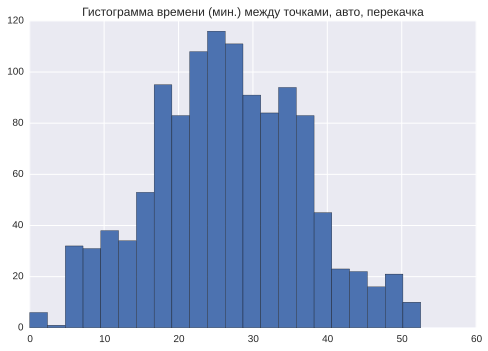

In [189]:
ax=(distances[distances < distances.quantile(0.95)].distance_time/60).hist(bins=22)
ax.set_title(u'Гистограмма времени (мин.) между точками, авто, перекачка')

In [130]:
distances_matrix = distances.pivot_table(index='origin', columns='destination', values='distance_time').fillna(0)

In [131]:
distances_matrix.to_csv('distances_matrix_transit.csv')

In [144]:
distances_matrix = pd.read_csv('distances_matrix_transit.csv', index_col=0)
distances_matrix = pd.read_csv('distances_matrix.csv', index_col=0)

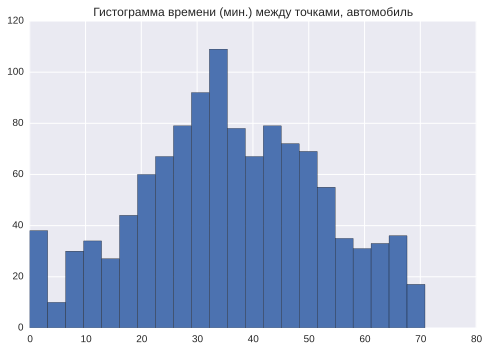

In [164]:
distances=distances_matrix.unstack().reset_index()[0]
ax=(distances[distances < distances.quantile(0.95)]/60).hist(bins=22)
ax.set_title(u'Гистограмма времени (мин.) между точками, автомобиль')

# TSP

In [169]:
! pip install git+https://github.com/dmishin/tsp-solver.git --user

  Cloning https://github.com/dmishin/tsp-solver.git to /tmp/pip-lya3cq-build
  Running setup.py install for tsp-solver ... - \ done


In [190]:
from tsp_solver.greedy import solve_tsp

#Prepare the square symmetric distance matrix for 3 nodes:
#  Distance from 0 to 1 is 1.0
#                1 to 2 is 3.0
#                0 to 2 is 2.0
D = [[ 0, 1.0, 2.0],
     [ 1.0, 0, 3.0],
     [ 2.0, 3.0, 0]]

path = solve_tsp( D )

# will print [1,0,2], path with total length of 3.0 units
print path


[1, 0, 2]


In [191]:
path = solve_tsp( distances_matrix.values )


In [192]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


Total time is 476.2 minutes, 7.9 hours. This does NOT include search time (approx +1.5h) and rest


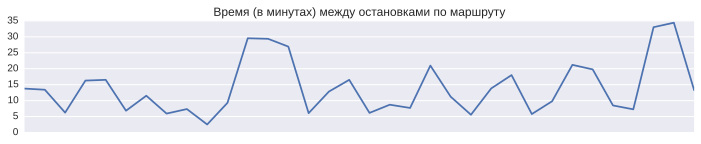

In [193]:
total_time = []
for origin, destination in pairwise(path):
    total_time.append(distances_matrix.values[origin, destination])
print 'Total time is %.1f minutes, %.1f hours.' % (sum(total_time)/60, sum(total_time)/60/60),
print 'This does NOT include search time (approx +1.5h) and rest'
ax = (pd.DataFrame(total_time)[0]/60).plot(figsize=(12,2), title=u'Время (в минутах) между остановками по маршруту')
ax.axes.get_xaxis().set_visible(False)


# визуализация


In [194]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key="AIxxxxxxxxxxxxxxxxxxxxxxxx")


In [198]:
'; '.join(coords_path)

'55.694789 37.812606; 55.743198 37.848017; 55.704758 37.845403; 55.715373 37.807306; 55.730198 37.739582; 55.739863 37.674642; 55.753433 37.663494; 55.730066 37.630939; 55.736098 37.649669; 55.735378 37.662102; 55.73481 37.66521; 55.722193 37.672855; 55.635869 37.732341; 55.643967 37.603837; 55.720585 37.567042; 55.71802 37.573753; 55.694855 37.558508; 55.678961 37.500621; 55.684772 37.481702; 55.696387 37.494827; 55.673199 37.454932; 55.735317 37.459684; 55.725367 37.454375; 55.747794 37.425674; 55.793419 37.497773; 55.78074 37.586679; 55.795813 37.585017; 55.817314 37.598582; 55.863581 37.695582; 55.860489 37.602948; 55.8611 37.585547; 55.880778 37.587865; 55.848402 37.379914; 55.980155 37.17173; 56.007629 37.202865'

In [150]:
coords_path=distances_matrix.index[path]

# Latitude-longitude pairs
start = map(float, coords_path[0].split(' '))
waypoints = map(lambda p: map(float, p.split()), coords_path[1:24])
end = map(float, coords_path[24].split())

m = gmaps.Map(height='650px')
ochDirections = gmaps.directions_layer(start, end, waypoints=waypoints)
m.add_layer(ochDirections)


start = map(float, coords_path[24].split(' '))
waypoints = map(lambda p: map(float, p.split()), coords_path[25:-1])
end = map(float, coords_path[-1].split())
ochDirections = gmaps.directions_layer(start, end, waypoints=waypoints)
m.add_layer(ochDirections)
m

In [89]:
IPython.display.HTML('<iframe src="https://api-maps.yandex.ru/frame/v1/-/C6El54Pa" width="100%" height="600" frameborder="0"></iframe>')

In [199]:
base_yandex = 'https://yandex.ru/maps/213/moscow/?ll=37.519600%2C55.819741&z=10&mode=routes&rtext={rtext}&rtt=mt&rtm=atm'
rtext = '~'.join(i.replace(' ', '%2C') for i in coords_path)
print base_yandex.format(rtext=rtext)

https://yandex.ru/maps/213/moscow/?ll=37.519600%2C55.819741&z=10&mode=routes&rtext=55.694789%2C37.812606~55.743198%2C37.848017~55.704758%2C37.845403~55.715373%2C37.807306~55.730198%2C37.739582~55.739863%2C37.674642~55.753433%2C37.663494~55.730066%2C37.630939~55.736098%2C37.649669~55.735378%2C37.662102~55.73481%2C37.66521~55.722193%2C37.672855~55.635869%2C37.732341~55.643967%2C37.603837~55.720585%2C37.567042~55.71802%2C37.573753~55.694855%2C37.558508~55.678961%2C37.500621~55.684772%2C37.481702~55.696387%2C37.494827~55.673199%2C37.454932~55.735317%2C37.459684~55.725367%2C37.454375~55.747794%2C37.425674~55.793419%2C37.497773~55.78074%2C37.586679~55.795813%2C37.585017~55.817314%2C37.598582~55.863581%2C37.695582~55.860489%2C37.602948~55.8611%2C37.585547~55.880778%2C37.587865~55.848402%2C37.379914~55.980155%2C37.17173~56.007629%2C37.202865&rtt=mt&rtm=atm


In [95]:
len(coords_path)

35

In [ ]:
https://www.google.ru/maps/dir/55.694789+37.812606/55.743198+37.848017/55.704758+37.845403/55.715373+37.807306/@55.7189082,37.7981099,13z/data=!4m18!4m17!1m3!2m2!1d37.812606!2d55.694789!1m3!2m2!1d37.848017!2d55.743198!1m3!2m2!1d37.845403!2d55.704758!1m3!2m2!1d37.807306!2d55.715373!3e0?hl=en

In [157]:
base_google = 'https://www.google.ru/maps/dir/{directions}/@55.7189082,37.7981099,13z/'
directions =  '/'.join(i.replace(' ', '+') for i in coords_path)
print base_google.format(directions=directions)

https://www.google.ru/maps/dir/55.694789+37.812606/55.743198+37.848017/55.704758+37.845403/55.715373+37.807306/55.730198+37.739582/55.739863+37.674642/55.753433+37.663494/55.730066+37.630939/55.736098+37.649669/55.735378+37.662102/55.73481+37.66521/55.722193+37.672855/55.635869+37.732341/55.643967+37.603837/55.720585+37.567042/55.71802+37.573753/55.694855+37.558508/55.678961+37.500621/55.684772+37.481702/55.696387+37.494827/55.673199+37.454932/55.735317+37.459684/55.725367+37.454375/55.747794+37.425674/55.793419+37.497773/55.78074+37.586679/55.795813+37.585017/55.817314+37.598582/55.863581+37.695582/55.860489+37.602948/55.8611+37.585547/55.880778+37.587865/55.848402+37.379914/55.980155+37.17173/56.007629+37.202865/@55.7189082,37.7981099,13z/


In [ ]:
base_google =  '/'.join(i.replace(' ', '+') for i in coords_path)

In [155]:
dir

<function dir>